In [1]:
import sys
sys.path.insert(0,'../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from starter.ml import model, data

# Load data

In [2]:
df = pd.read_csv("../data/census.csv")
df.columns = df.columns.str.strip()

## Explore the data

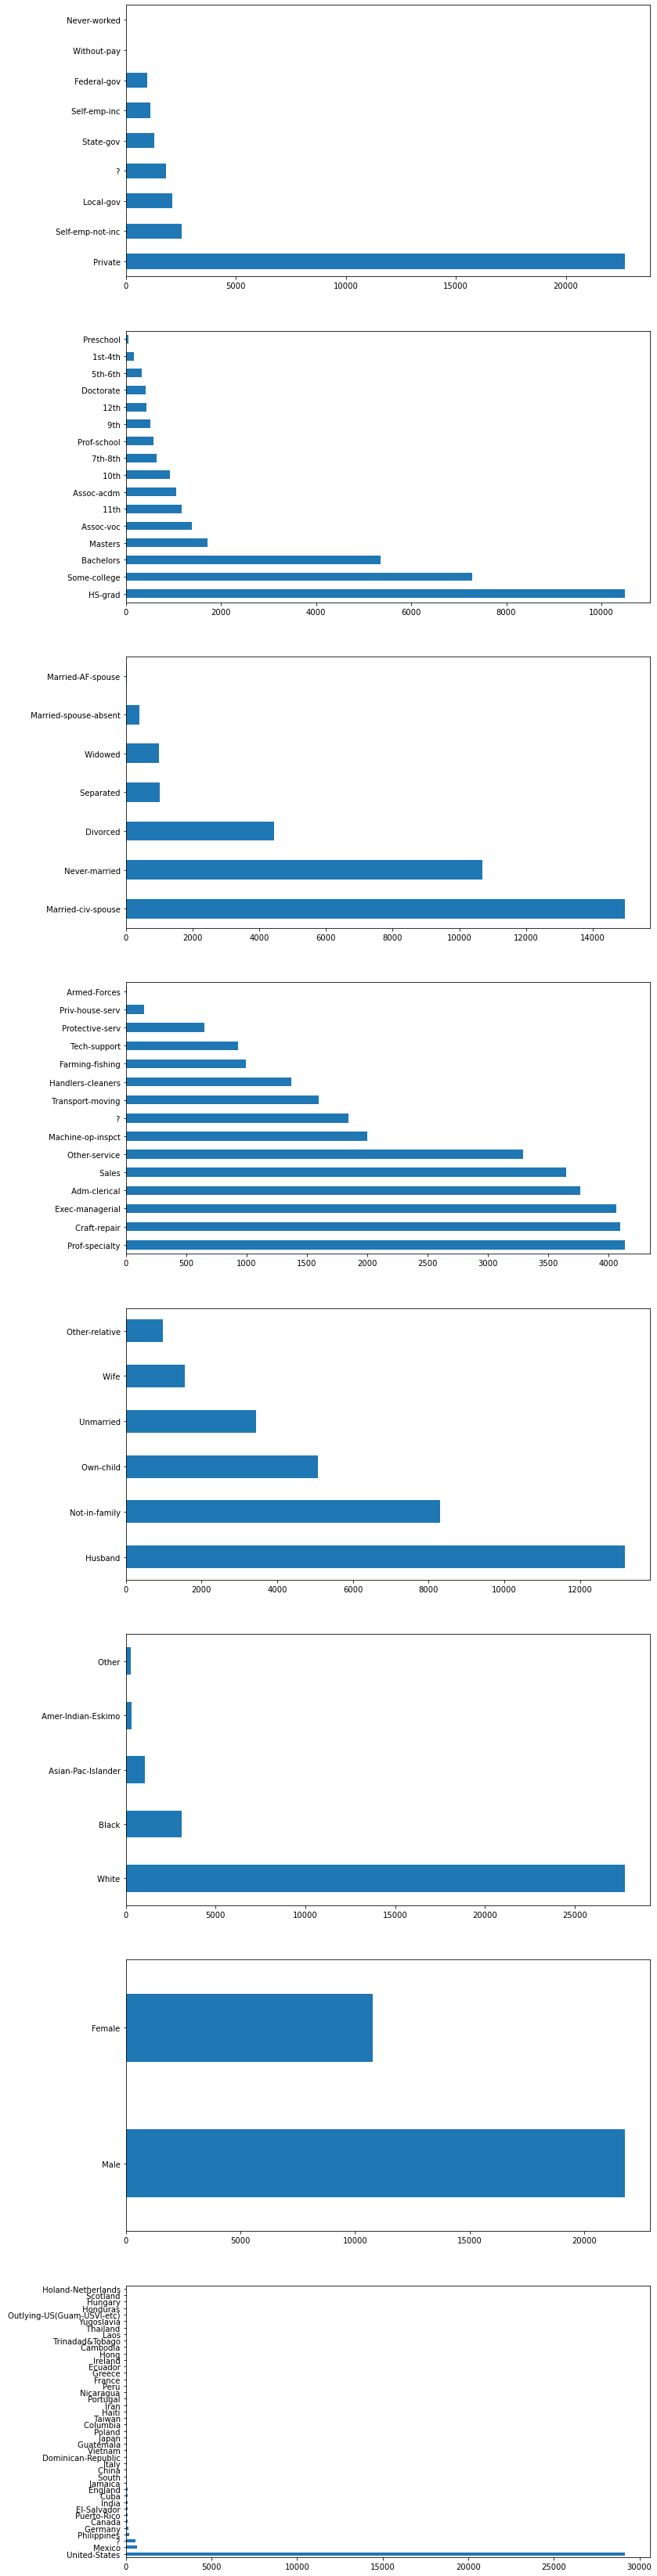

In [3]:
cat_features = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
]

fig, axes = plt.subplots(nrows = len(cat_features))

for c, ax in zip(cat_features, axes.ravel()):
    df[c].value_counts().plot.barh(ax = ax, figsize = (12, 60))

In [4]:
df["salary"].value_counts(normalize = True)

 <=50K    0.75919
 >50K     0.24081
Name: salary, dtype: float64

# Data slices

In [5]:
X_train, y_train, encoder, lb = data.process_data(
    df, categorical_features=cat_features, label="salary", training=True
)

## Save X_train and y_train

In [6]:
# save for testing
np.savetxt("../data/X_train.txt", X_train, delimiter = ",")
np.savetxt("../data/y_train.txt", y_train, delimiter = ",")

## Load trained model and encoders

In [7]:
import joblib

classifier = joblib.load("../model/model.pkl")
lb = joblib.load("../model/lb.pkl")
encoder = joblib.load("../model/encoder.pkl")
classifier

RandomForestClassifier(random_state=42)

## Compute model metrics on slices

In [8]:
from starter.ml.model import compute_model_metrics
from sklearn.base import ClassifierMixin
from tqdm.auto import trange

In [9]:
def compute_model_metrics_slices(model: ClassifierMixin, df: pd.DataFrame) -> pd.DataFrame:
    """compute model metrics on slices of categorical data

    Args:
        model (ClassifierMixin): sklearn classifier
        df (pd.DataFrame): dataframe used to train and validate model

    Returns:
        pd.DataFrame: metrics on slices sorted by f1_score
    """
    cat_features = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
    ]
    # Get test data with same seed as for training
    _, test = train_test_split(df, test_size=0.20, random_state=42)
    X_test, y_test, _ , _ = data.process_data(
        test, categorical_features=cat_features, label = "salary", 
        training = False, encoder = encoder, lb = lb)
    
    encoded_feature = encoder.get_feature_names_out()
    n_features = X_train.shape[1]

    # predict for only data where ohe(category_subcategory) == 1
    performance_dict = {}
    for k in trange(6, n_features):
        mask = (X_test[:, k] == 1)
        try:
            preds = model.predict(X_test[mask])
            performance_dict[encoded_feature[k - 6]] = compute_model_metrics(y_test[mask], preds)
        except ValueError:
            # if subcategory is not in test, then return nan
            performance_dict[encoded_feature[k - 6]] = (np.nan, np.nan, np.nan)
            
    performance = pd.DataFrame.from_dict(performance_dict, 
                            orient = "index",
                            columns = ["precision", "recall", "f1"])

    # map xk_ to category name
    x2cat = dict(zip([f"x{k}" for k in range(len(cat_features))], cat_features))
    # Add category column to performance dataframe
    performance["category"] = performance.index.str.extract(r"(x\d)")[0].map(x2cat).values
    performance.index = performance.index.str.replace(r"(x\d_ )", "", regex = True)

    return performance.sort_values(by = "f1", ascending = False)

compute_model_metrics_slices(classifier, df)
    

  0%|          | 0/102 [00:00<?, ?it/s]

,precision,recall,f1,category
Yugoslavia,1.0,1.000000,1.000000,native-country
Amer-Indian-Eskimo,1.0,1.000000,1.000000,race
Italy,1.0,1.000000,1.000000,native-country
Ireland,1.0,1.000000,1.000000,native-country
Married-AF-spouse,1.0,1.000000,1.000000,marital-status
...,...,...,...,...
Mexico,1.0,0.666667,0.800000,native-country
Ecuador,1.0,0.500000,0.666667,native-country
Never-worked,NaN,NaN,NaN,workclass
Holand-Netherlands,NaN,NaN,NaN,native-country


In [10]:
from starter.ml.model import compute_model_metrics_slices

compute_model_metrics_slices(classifier, encoder, lb, df)

  0%|          | 0/102 [00:00<?, ?it/s]

,precision,recall,f1,category
Yugoslavia,1.0,1.000000,1.000000,native-country
Amer-Indian-Eskimo,1.0,1.000000,1.000000,race
Italy,1.0,1.000000,1.000000,native-country
Ireland,1.0,1.000000,1.000000,native-country
Married-AF-spouse,1.0,1.000000,1.000000,marital-status
...,...,...,...,...
Mexico,1.0,0.666667,0.800000,native-country
Ecuador,1.0,0.500000,0.666667,native-country
Never-worked,NaN,NaN,NaN,workclass
Holand-Netherlands,NaN,NaN,NaN,native-country
